In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

In [3]:
trainingDirectory = './train/'
testingDirectory = './test/'

rows, columns = 48 , 48
classes = 7

def countExpressions(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir = path + expression
        dict_[expression] = len(os.listdir(dir))
    df = pd.DataFrame(dict_, index=[set_])
    return df
trainCount = countExpressions(trainingDirectory, 'train')
testCount = countExpressions(testingDirectory, 'test')
print(trainCount)
print(testCount)


       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


<AxesSubplot:>

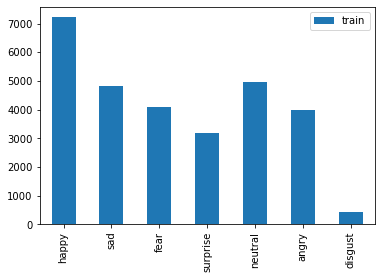

In [3]:
trainCount.transpose().plot(kind = 'bar')

<AxesSubplot:>

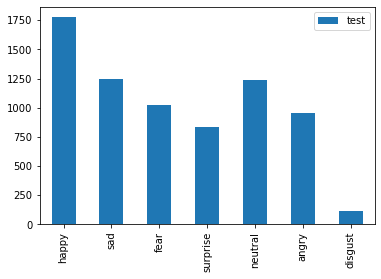

In [4]:
testCount.transpose().plot(kind = 'bar')

The snippet underneath has some kind of bug with pillow

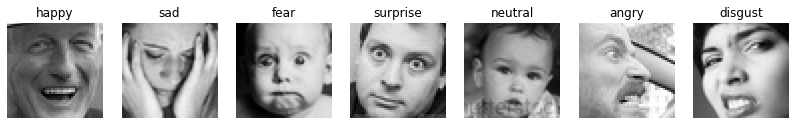

In [4]:
plt.figure(figsize = (14,22))
index = 1
for expression in os.listdir(trainingDirectory):
    image = load_img(trainingDirectory + expression + '/' + os.listdir(trainingDirectory + expression)[5])
    plt.subplot(1,7,index)
    plt.imshow(image)
    plt.title(expression)
    plt.axis('off')
    index += 1
plt.show()

Train test and validation datasets

In [5]:
trainDataGenerator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)

trainingSet = trainDataGenerator.flow_from_directory(trainingDirectory,batch_size=64,target_size=(48,48),shuffle=True,color_mode='rgb',class_mode='categorical',subset='training')

validationSet = trainDataGenerator.flow_from_directory(trainingDirectory,batch_size=64,target_size=(48,48),shuffle=True,color_mode='rgb',class_mode='categorical',subset='validation')

testDataGenerator = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

testSet = testDataGenerator.flow_from_directory(testingDirectory,batch_size=64,target_size=(48,48),shuffle=True,color_mode='rgb',class_mode='categorical')


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:
trainingSet.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

MODEL ARCHITECTURE - SANITY DEATH

In [6]:
weightDecay = 1e-4

numberOfClasses = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4),padding = 'same', kernel_regularizer=regularizers.l2(weightDecay),input_shape=(48,48,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4),padding = 'same', kernel_regularizer=regularizers.l2(weightDecay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))



Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-09 14:24:36.116359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 14:24:36.116712: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.add(Conv2D(128,(4,4),padding='same',kernel_regularizer=regularizers.l2(weightDecay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

In [8]:
model.add(Conv2D(128,(4,4),padding='same',kernel_regularizer=regularizers.l2(weightDecay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(4,4),padding='same',kernel_regularizer=regularizers.l2(weightDecay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='linear'))
model.add(Activation('elu'))
model.add(Dense(numberOfClasses,activation='softmax'))


In [9]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.0003),metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        3136      
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        65600     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

In [10]:
checkpointer = [EarlyStopping(monitor = 'accuracy',verbose=1,restore_best_weights=True,mode='max',patience=10),
    ModelCheckpoint(
        filepath='model.weights.best.hdf5',
        monitor='accuracy',
        verbose=1,
        save_best_only=True,
        mode = 'max'
            )
]

Model Training

In [11]:
stepsPerEpoch = trainingSet.batch_size
validationSteps = validationSet.batch_size

history = model.fit(x=trainingSet,
    epochs=200,
    callbacks=[checkpointer],
    steps_per_epoch = stepsPerEpoch,
    validation_steps = validationSteps
)

Epoch 1/200


2022-03-09 14:24:49.223502: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-09 14:24:49.604752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 2.1696 - accuracy: 0.2593
Epoch 1: accuracy improved from -inf to 0.25928, saving model to model.weights.best.hdf5
64/64 [==============================] - 15s 218ms/step - loss: 2.1696 - accuracy: 0.2593
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.7678 - accuracy: 0.3088
Epoch 2: accuracy improved from 0.25928 to 0.30884, saving model to model.weights.best.hdf5
64/64 [==============================] - 14s 220ms/step - loss: 1.7678 - accuracy: 0.3088
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.7234 - accuracy: 0.3435
Epoch 3: accuracy improved from 0.30884 to 0.34351, saving model to model.weights.best.hdf5
64/64 [==============================] - 14s 218ms/step - loss: 1.7234 - accuracy: 0.3435
Epoch 4/200
64/64 [==============================] - ETA: 0s - loss: 1.6772 - accuracy: 0.3628
Epoch 4: accuracy improved from 0.34351 to 0.36277, saving model to model.weights.best.hd

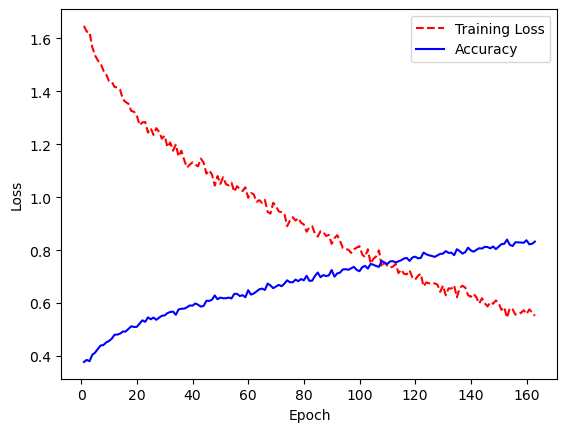

In [29]:
trainingLoss = history.history['loss']
val_loss = history.history['accuracy']
plt.rcParams['figure.figsize'] = [10,5]
plt.style.use(['default'])

epochCount = range(1,len(trainingLoss) + 1)

plt.plot(epochCount,trainingLoss,'r--')
plt.plot(epochCount,val_loss,'b-')
plt.legend(['Training Loss', 'Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [30]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

KeyError: 'val_accuracy'

In [31]:
h = history.history
print(h.keys())

dict_keys(['loss', 'accuracy'])


In [12]:
model.save('facial_expression2.h5')

In [35]:
print(f"Test accuracy = {model.evaluate(testSet ,batch_size=testSet.batch_size,steps=testSet.n // testSet.batch_size)[1]*100}%")

2022-03-09 12:48:24.245423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - 12s 100ms/step - loss: 1.3277 - accuracy: 0.6239
Test accuracy = 62.38839626312256%


Confusion matrix on training set

In [1]:
import cv2
import keras.models
import numpy as np
emotion_dict = {0: 'fear',
                1: 'anger',
                2: 'disgust',
                3: 'happiness',
                4: 'neutral',
                5: 'sadness',
                6: 'surprise'}
model = keras.models.load_model('./facial_expression2.h5')

capture = cv2.VideoCapture(0)

while True:
    ret, frame = capture.read()
    frame = cv2.resize(frame, (1280, 720))

    if not ret:
        break

    face_detector = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

    # detect faces available on camera
    num_faces = face_detector.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=5)
    # take each face available on the camera and Preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y - 50), (x + w, y + h + 10), (0, 255, 0), 4)
        roi_frame = frame[y:y + h, x:x + w]
        # print(roi_frame.shape)
        # x = roi_frame.reshape(None,48,48,1)
        # print(x.shape)

        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_frame, (48, 48)), -1), 0)
        
        # predict the emotions
        emotion_prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2,
                    cv2.LINE_AA)

    cv2.imshow('Detekt', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()

2022-03-10 08:54:46.639352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-10 08:54:46.639593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-10 08:54:49.069594: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-10 08:54:49.212131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 